# Purpose if this notebook
Fit multiple machine learning models to see if any one performs better than the logistic regression model.
Complete the following steps:
1. pick a number of classifiers and write a funciton to automate model fitting
2. calculate area under receiver operating characteristic curve (AUROC) and average precision (AP) for each model
3. plot receiver operating characteristic and precision-recall curves for all models.
4. pick the best model based on AUROC and AP scores.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
# load the wrangled table
wrangled_data = pd.read_csv('../data/processed/df_p09_cv09_sorted.csv')

In [2]:
# final count of labels 0 and 1
wrangled_data.groupby('OUTPUT_LABEL')['OUTPUT_LABEL'].count()

OUTPUT_LABEL
0.0    35682
1.0     2529
Name: OUTPUT_LABEL, dtype: int64

In [3]:
# check if there are empty values
wrangled_data.isna().sum().sum()

0

In [4]:
# quick look at the columns
wrangled_data.columns

Index(['Unnamed: 0', 'OUTPUT_LABEL', '1Y_PRIOR_ADM', 'LENGTH_OF_STAY_DAYS',
       'AGE', 'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT',
       'ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI',
       'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM',
       'ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR',
       'DISCHARGE_LOCATION_DISC-TRAN CANCER/CHLDRN H',
       ...
       'tissu', 'tract', 'transplant', 'trauma', 'traumat', 'ulcer',
       'vascular', 'ventil', 'without', 'wo'],
      dtype='object', length=190)

In [5]:
wrangled_data.drop('Unnamed: 0', axis=1, inplace=True)
y = wrangled_data.OUTPUT_LABEL.values
X = wrangled_data.drop(['OUTPUT_LABEL'], axis=1).values
print(y.shape)
print(X.shape)

(38211,)
(38211, 188)


In [6]:
# Set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

# split the data into train and test sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

# scaling is necessary for some algorithms, such as SVM and neural nets, scale the data to min-max 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [8]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# import model metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# import ROC_AUC scoring, we will use area under the ROC curve for comparison
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED, class_weight='balanced')

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")

In [9]:
models = get_models()
P = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
score_models(P, ytest)

Fitting models.
svm... Time elapsed  10:22:31.125582
done
knn... Time elapsed  0:00:45.366614
done
naive bayes... Time elapsed  0:00:00.217344
done
mlp-nn... Time elapsed  0:00:04.820420
done
random forest... Time elapsed  0:00:00.699649
done
gbm... Time elapsed  0:01:08.098700
done
logistic... Time elapsed  0:00:01.329552
done
Done.

Scoring models.
svm                       : 0.650, 0.139
knn                       : 0.588, 0.099
naive bayes               : 0.651, 0.112
mlp-nn                    : 0.696, 0.148
random forest             : 0.592, 0.099
gbm                       : 0.712, 0.173
logistic                  : 0.743, 0.168
Done.



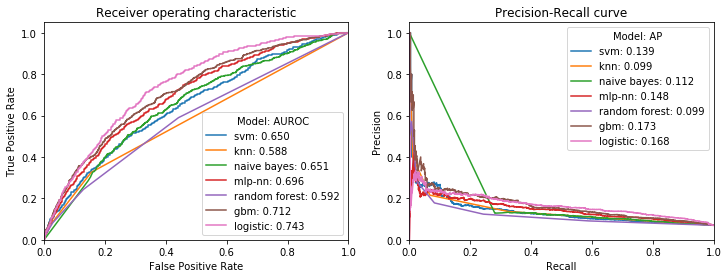

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
    
plt.savefig('../reports/figures/mult_models_after_feat_select.png', format='png')

## Alhtough GBM has higher precision it also has lower AUROC. In addition, it is a more complex ensemble model. Hence, logistic regression is still the best performing and simplest model.